## Predicting House Prices
### Problem:
- **Objective**: Predict house prices. 
- **How**: Building a Feedforward Neural Network.
- **Dataset**: Various features about houses (e.g., square footage, number of bedrooms, furnished status).
- **Target variable**: House price

### Steps:
**Load the Dataset**: Housing dataset coming from Kaggle ([Link Here](https://www.kaggle.com/datasets/yasserh/housing-prices-dataset))

**Preprocess the Data**:
  1) Convert categorical columns into numerical representations
  2) Separate features and target (price)
  3) Split data into training and testing sets
  4) Scale input features
  5) Scale target (price)
  6) Convert features and labels to tensors

**Build the Neural Network**: Feedforward Neural Network with the following layers:

*Input Layer*: Match the number of input features.

*Hidden Layers*: Two hidden layers with ReLU activation (512 and 256 units).

*Dropout Layers*: After each of the first two layers, dropout is applied with a probability of 0.3 to prevent overfitting.

*Output Layer*: One neuron for the continuous output (price).

**Train the Model**: 
 1) Use the MSE loss function and Adam optimizer. 
 2) Train for 400 epochs.
 3) Calculate and print the validation loss during training.

**Evaluate the Model**:  
 1) Calculate test loss after training.
 2) Plot training VS validation loss curves
 3) Calculate R-squared

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader

In [2]:
housing_data = pd.read_csv('Housing.csv')

In [3]:
housing_data.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [4]:
housing_data[['mainroad','guestroom','basement','hotwaterheating','airconditioning','prefarea']] = housing_data[['mainroad','guestroom','basement','hotwaterheating','airconditioning','prefarea']].replace({'yes': 1, 'no': 0}).astype(int)

In [5]:
housing_data.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


In [6]:
housing_data['furnishingstatus']=LabelEncoder().fit_transform(housing_data['furnishingstatus'])

In [7]:
housing_data.tail()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
540,1820000,3000,2,1,1,1,0,1,0,0,2,0,2
541,1767150,2400,3,1,1,0,0,0,0,0,0,0,1
542,1750000,3620,2,1,1,1,0,0,0,0,0,0,2
543,1750000,2910,3,1,1,0,0,0,0,0,0,0,0
544,1750000,3850,3,1,2,1,0,0,0,0,0,0,2


In [8]:
class HouseData(Dataset):
    def __init__(self, file_path, train=True, test_size=0.2, random_state=42):
        housing_data = pd.read_csv(file_path)

        # Step 1: Preprocessing categorical data
        # Convert categorical columns into numerical representations
        housing_data[['mainroad','guestroom','basement','hotwaterheating','airconditioning','prefarea']] = housing_data[['mainroad','guestroom','basement','hotwaterheating','airconditioning','prefarea']].replace({'yes': 1, 'no': 0}).astype(int)
        housing_data['furnishingstatus']=LabelEncoder().fit_transform(housing_data['furnishingstatus'])
        
        # Separate features and target (price)
        X=housing_data.drop("price",axis=1)
        y=housing_data["price"]

        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

        # Scale input features
        scaler_X = StandardScaler()
        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)

        # Scale target (price)
        scaler_y = StandardScaler()
        y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()  # Flatten after scaling
        y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

        if train:
            self.X = X_train_scaled
            self.y = y_train_scaled  # Normalize target
        else:
            self.X = X_test_scaled
            self.y = y_test_scaled
    
        
        # Convert features and labels to tensors
        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32).view(-1, 1)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [9]:
csv_file = 'Housing.csv'  # Replace with the actual path to your file
train_dataset = HouseData(csv_file, train=True)
test_dataset = HouseData(csv_file, train=False)

In [10]:
class HouseNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(HouseNN, self).__init__()
        # Define the layers
        self.linear1 = nn.Linear(input_size, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, output_size)
        self.dropout = nn.Dropout(p=0.3)
    
    def forward(self, x):
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.linear3(x)

        return x

In [11]:
X_train, X_val, y_train, y_val = train_test_split(train_dataset.X, train_dataset.y, test_size=0.2, random_state=42)

In [12]:
#Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]  # Number of features in the dataset
output_size = 1  # Predicting house prices (a single output)
model_h = HouseNN(input_size=input_size, output_size=output_size)

In [13]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model_h.parameters(), lr=1e-5)

In [14]:
epochs = 400

# Lists to store losses for plotting
train_losses = np.array([])
val_losses = np.array([])

for epoch in range(epochs):
    model_h.train()
    optimizer.zero_grad()
        
    pred = model_h(X_train)
    train_loss = loss_fn(pred, y_train)

    train_loss.backward()
    optimizer.step()

    model_h.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        val_pred = model_h(X_val)
        val_loss = loss_fn(val_pred, y_val)

    # Print training and validation loss every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{epochs}, Train Loss: {train_loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

    train_losses = np.append(train_losses, train_loss.item())
    val_losses = np.append(val_losses, val_loss.item())

Epoch 0/400, Train Loss: 0.9552, Validation Loss: 0.9432
Epoch 10/400, Train Loss: 0.9252, Validation Loss: 0.9079
Epoch 20/400, Train Loss: 0.8812, Validation Loss: 0.8741
Epoch 30/400, Train Loss: 0.8301, Validation Loss: 0.8418
Epoch 40/400, Train Loss: 0.8198, Validation Loss: 0.8109
Epoch 50/400, Train Loss: 0.7718, Validation Loss: 0.7814
Epoch 60/400, Train Loss: 0.7626, Validation Loss: 0.7531
Epoch 70/400, Train Loss: 0.7248, Validation Loss: 0.7261
Epoch 80/400, Train Loss: 0.6748, Validation Loss: 0.7001
Epoch 90/400, Train Loss: 0.6622, Validation Loss: 0.6752
Epoch 100/400, Train Loss: 0.6416, Validation Loss: 0.6511
Epoch 110/400, Train Loss: 0.6255, Validation Loss: 0.6282
Epoch 120/400, Train Loss: 0.5818, Validation Loss: 0.6064
Epoch 130/400, Train Loss: 0.5764, Validation Loss: 0.5859
Epoch 140/400, Train Loss: 0.5792, Validation Loss: 0.5664
Epoch 150/400, Train Loss: 0.5459, Validation Loss: 0.5480
Epoch 160/400, Train Loss: 0.5061, Validation Loss: 0.5308
Epoch 17

In [15]:
model_h.eval()

with torch.no_grad():
    predictions = model_h(test_dataset.X)
    loss = loss_fn(predictions, test_dataset.y)
test_loss = loss / len(test_dataset.X)

In [16]:
print(f'Test Loss: {loss.item()}')

Test Loss: 0.5876004695892334


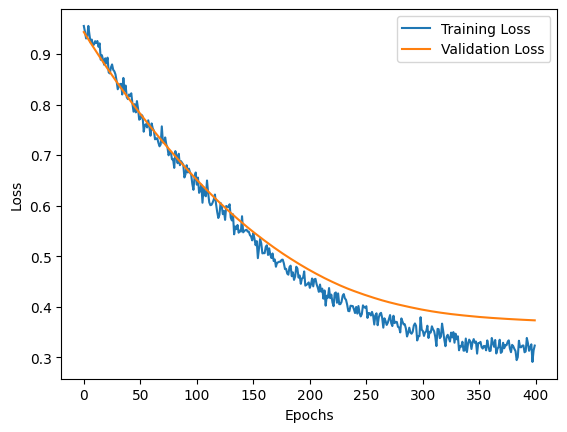

In [17]:
# Plot loss curves
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import r2_score
r2 = r2_score(test_dataset.y, predictions)
print(f"R-squared: {r2:.4f}")

R-squared: 0.6416
